<a href="https://colab.research.google.com/github/khalit7/Computer_Vision_Models_Analysis/blob/main/Image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Imports

In [ ]:
!pip install torchviz

  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4150 sha256=fb7bf4b23b3db683c22852bb7e706c7d943ff40c454a53f165663141f55eb8ad
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


In [1]:
import os
import time
import math

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset,random_split
from torch import Tensor

from typing import Optional, Tuple, List, Callable, Any
import torchvision
from torchvision import transforms
import torchvision.models as models
from torchvision.utils import make_grid
#from torchsummary import summary
from sklearn.metrics import accuracy_score
from PIL import Image
#from torchviz import make_dot
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
BATCH_SIZE=128

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Dataset Viusalization

In [ ]:
def visualize_data(data_loader):
  for images,labels in data_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

## MNIST

In [ ]:
MNIST_data =   torchvision.datasets.MNIST('.', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
MNIST_data_loader = torch.utils.data.DataLoader(MNIST_data,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)
len(MNIST_data_loader)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



469

In [ ]:
MNIST_classes = MNIST_data.classes
MNIST_classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([128, 1, 28, 28])


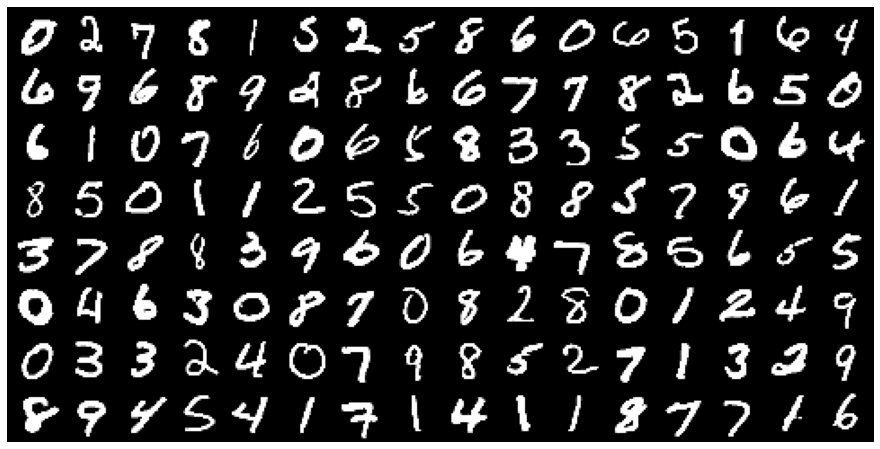

In [ ]:
visualize_data(MNIST_data_loader)

## CIFAR

In [ ]:
data_transform = transforms.Compose([
                                      transforms.ToTensor(), 
                                      transforms.Normalize((0.5,0.5,0.5,), (0.5,0.5,0.5))])

CIFAR_data =   torchvision.datasets.CIFAR10('.', train=True, download=True,
                             transform=data_transform)
CIFAR_data_loader = torch.utils.data.DataLoader(CIFAR_data,
                                          batch_size=BATCH_SIZE,
                                          shuffle=True)
print(len(CIFAR_data_loader))

Files already downloaded and verified
391


In [ ]:
CIFAR_classes = CIFAR_data.classes
CIFAR_classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([128, 3, 32, 32])


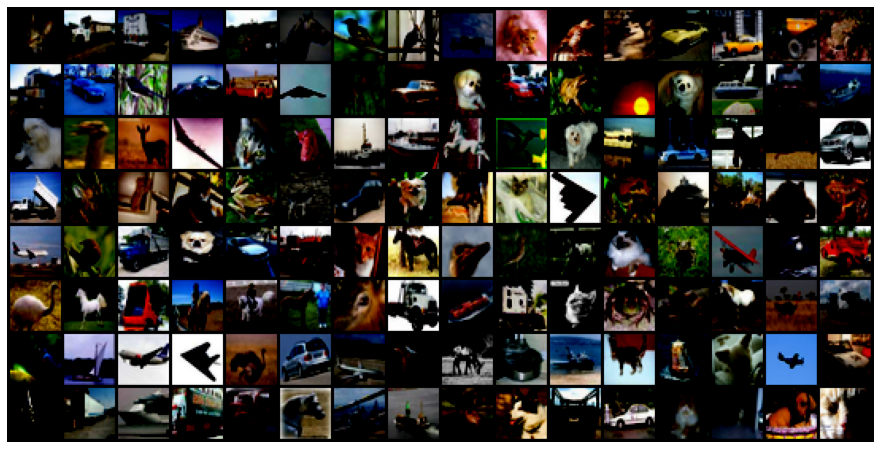

In [ ]:
visualize_data(CIFAR_data_loader)

#Training and validation boilerplate

In [4]:
obj_func = nn.CrossEntropyLoss()

In [5]:
def training_step(model,optimizer,dataloader,is_googleNet):
  avg_loss=0
  correct_preds=0
  for batch_idx,(img,label) in enumerate(dataloader):
    img,label = img.to(device), label.to(device)
    # zero the parameter gradients
    optimizer.zero_grad()

    #
    if is_googleNet:
      output,aux2,aux1 = model(img)
      loss1 = obj_func(output,label)
      loss2 = obj_func(aux1,label)
      loss3 = obj_func(aux2,label)
      loss = loss1 + 0.3* (loss2 + loss3)
    else:
      output = model(img)
      loss = obj_func(output,label)
    
    #
    loss.backward()
    optimizer.step()

    # accumulate batch loss
    avg_loss+=loss
    # calculate number of correct predictions
    preds = torch.argmax(output,axis=1)
    correct_preds += torch.sum(preds==label)
  # calculate avg losses
  avg_loss /= len(dataloader.dataset)
  # clculate accuracy
  acc = correct_preds/len(dataloader.dataset)
  return avg_loss.cpu().detach(),acc.cpu()

In [6]:
def evaluate(model,dataloader,is_googleNet):
  loss = 0
  correct_preds = 0
  for batch_idx,(img,label) in enumerate(dataloader):
    img,label = img.to(device), label.to(device)
    
    with torch.no_grad():
      if is_googleNet:
        output,_,_ = model(img)
      else:
        output = model(img)
    
    loss = obj_func(output,label)
    
    # accumulate bactch loss
    loss += obj_func(output,label)

    # calculate number of correct predictions
    preds = torch.argmax(output,axis=1)
    correct_preds += torch.sum(preds==label)
  
  # calculate average loss
  loss /= len(dataloader.dataset)
  # clculate accuracy
  acc = correct_preds/len(dataloader.dataset)
  return loss.cpu(),acc.cpu()

In [7]:
NUM_EPOCHS = 10
def train(model,optimizer,train_loader,val_loader,num_epochs=NUM_EPOCHS,save_path="./",evaluate_every_epoch = 1,is_googleNet=False):
    training_loss_history = []
    training_acc_history = []
    val_loss_history = []
    val_acc_history = []
    best_acc = 0
    print("Training starting ... ")
    print()
    for epoch in range(num_epochs):
      # set timer to zero
      start = time.time()
      #
      print("Epoch number {} --------------------------------------------------".format(epoch+1))
      train_loss,train_acc = training_step(model,optimizer,train_loader,is_googleNet)
      training_loss_history.append(train_loss)
      training_acc_history.append(train_acc)
      print(" Training Loss = {}, Training Accuracy = {:0.2%} ".format(train_loss,train_acc))
      #
      end = time.time()
      print("Time taken for an epoch {:0.2} second".format(start-end))
      if ((epoch+1)%evaluate_every_epoch)==0:
        print("performing validation : ")
        val_loss,val_acc = evaluate(model,val_loader,is_googleNet)
        val_loss_history.append(val_loss)
        val_acc_history.append(val_acc)
        print(" validation  loss = {}, validation accuracy = {:0.2%} ".format(val_loss,val_acc))
        #TODO: if best val model, save model
        if val_acc > best_acc:
          print("Saving best model so far")
          best_acc = val_acc
          # save model
          torch.save(model.state_dict(), save_path)

    return training_loss_history,training_acc_history,val_loss_history,val_acc_history

In [8]:
def plot_helper(title,**kwargs):
  for curve_name,history in kwargs.items():
    plt.plot(history,label=curve_name)
  plt.legend()
  plt.title(title)

In [9]:
base_path = "/content/drive/MyDrive/computer vision project/"

In [10]:
# base_path = "./"

# Prepare dataset for all models (helper functions)

In [11]:
def get_CIFAR_resnet(batch_size = BATCH_SIZE):
  normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                      std=[0.229, 0.224, 0.225])

  train_loader = torch.utils.data.DataLoader(
          torchvision.datasets.CIFAR10(root='.',download=True, train=True, transform=transforms.Compose([
              transforms.RandomHorizontalFlip(),
              transforms.RandomCrop(32, 4),
              transforms.ToTensor(),
              normalize,
          ])),
          batch_size=BATCH_SIZE, shuffle=True,)

  val_loader = torch.utils.data.DataLoader(
          torchvision.datasets.CIFAR10(root='.', download=True, train=False, transform=transforms.Compose([
              transforms.ToTensor(),
              normalize,
          ])),
          batch_size=BATCH_SIZE, shuffle=False,)
  
  return train_loader,val_loader

def get_MNIST_resnet(batch_size = BATCH_SIZE):
    mnist = torchvision.datasets.MNIST(download=True, train=True, root=".").train_data.float()
    
    data_transform = transforms.Compose([ transforms.Resize((224, 224)),
                                         transforms.ToTensor(), 
                                         transforms.Normalize((mnist.mean()/255,), (mnist.std()/255,))])

    train_loader = DataLoader(torchvision.datasets.MNIST(download=True, root=".", transform=data_transform, train=True),
                              batch_size=BATCH_SIZE, shuffle=True)

    val_loader = DataLoader(torchvision.datasets.MNIST(download=True, root=".", transform=data_transform, train=False),
                            batch_size=BATCH_SIZE, shuffle=False)
    return train_loader, val_loader

def get_MNIST_googlenet(batch_size = BATCH_SIZE):
    mnist = torchvision.datasets.MNIST(download=True, train=True, root=".").train_data.float()
    
    data_transform = transforms.Compose([ transforms.Resize((224, 224)),
                                         transforms.ToTensor(), 
                                         transforms.Normalize((mnist.mean()/255,), (mnist.std()/255,))])

    train_loader = DataLoader(torchvision.datasets.MNIST(download=True, root=".", transform=data_transform, train=True),
                              batch_size=BATCH_SIZE, shuffle=True)

    val_loader = DataLoader(torchvision.datasets.MNIST(download=True, root=".", transform=data_transform, train=False),
                            batch_size=BATCH_SIZE, shuffle=False)
    return train_loader, val_loader

def get_CIFAR_googlenet(batch_size = BATCH_SIZE):

  transform = transforms.Compose([ transforms.Resize((224, 224)),
                                      transforms.ToTensor(), 
                                      transforms.Normalize((0.5,0.5,0.5,), (0.5,0.5,0.5))])


  trainset = torchvision.datasets.CIFAR10(root='.', train=True,
                                          download=True, transform=transform)
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True)

  testset = torchvision.datasets.CIFAR10(root='.', train=False,
                                        download=True, transform=transform)
  testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False)
  
  return trainloader,testloader


def get_MNIST_VGG(batch_size = BATCH_SIZE):
    mnist = torchvision.datasets.MNIST(download=True, train=True, root=".").train_data.float()
    
    data_transform = transforms.Compose([ transforms.Resize((224, 224)),
                                         transforms.ToTensor(), 
                                         transforms.Normalize((mnist.mean()/255,), (mnist.std()/255,)),
                                         transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # grayscale to RGB
                                         ])
    

    train_loader = DataLoader(torchvision.datasets.MNIST(download=True, root=".", transform=data_transform, train=True),
                              batch_size=BATCH_SIZE, shuffle=True,)

    val_loader = DataLoader(torchvision.datasets.MNIST(download=True, root=".", transform=data_transform, train=False),
                            batch_size=BATCH_SIZE, shuffle=False,)
    return train_loader, val_loader


def get_CIFAR_VGG(batch_size = BATCH_SIZE):

  transform = transforms.Compose([ transforms.Resize((224, 224)),
                                      transforms.ToTensor(), 
                                      transforms.Normalize((0.5,0.5,0.5,), (0.5,0.5,0.5))])


  trainset = torchvision.datasets.CIFAR10(root='.', train=True,
                                          download=True, transform=transform)
  trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                            shuffle=True)

  testset = torchvision.datasets.CIFAR10(root='.', train=False,
                                        download=True, transform=transform)
  testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                          shuffle=False)
  
  return trainloader,testloader

# Training

## ResNet Training

### Training on CIFAR

In [ ]:
cifar_train,cifar_val = get_CIFAR_resnet(batch_size=400)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out
resnet = ResNet9(3, 10).to(device)

In [ ]:
# First we define the optimizer
optimizer = torch.optim.Adam(resnet.parameters(), lr=3e-4)
# select path to save best model 
save_path = base_path + "Resnet/best_CIFAR"
#
training_loss_history,training_acc_history,val_loss_history,val_acc_history = train(resnet,optimizer,cifar_train,cifar_val,num_epochs=20,save_path=save_path,evaluate_every_epoch=1)

Training starting ... 

Epoch number 1 --------------------------------------------------
 Training Loss = 0.00924986507743597, Training Accuracy = 57.99% 
performing validation : 
 validation  loss = 0.00691803777590394, validation accuracy = 68.97% 
Saving best model so far
Epoch number 2 --------------------------------------------------
 Training Loss = 0.005674073938280344, Training Accuracy = 74.69% 
performing validation : 
 validation  loss = 0.005304413847625256, validation accuracy = 76.29% 
Saving best model so far
Epoch number 3 --------------------------------------------------
 Training Loss = 0.004457876551896334, Training Accuracy = 80.37% 
performing validation : 
 validation  loss = 0.004467837978154421, validation accuracy = 80.62% 
Saving best model so far
Epoch number 4 --------------------------------------------------
 Training Loss = 0.0037512769922614098, Training Accuracy = 83.52% 
performing validation : 
 validation  loss = 0.004131455905735493, validation a

In [ ]:
print(training_loss_history)
print(training_acc_history)
print(val_loss_history)
print(val_acc_history)
np.save(base_path + "Resnet/CIFAR_train_loss.npy",np.array(training_loss_history))
np.save(base_path + "Resnet/CIFAR_train_acc.npy",np.array(training_acc_history))
np.save(base_path + "Resnet/CIFAR_val_loss.npy",np.array(val_loss_history))
np.save(base_path + "Resnet/CIFAR_val_acc.npy",np.array(val_acc_history))

[tensor(0.0092), tensor(0.0057), tensor(0.0045), tensor(0.0038), tensor(0.0033), tensor(0.0029), tensor(0.0026), tensor(0.0024), tensor(0.0022), tensor(0.0019), tensor(0.0018), tensor(0.0016), tensor(0.0015), tensor(0.0014), tensor(0.0013), tensor(0.0012), tensor(0.0011), tensor(0.0010), tensor(0.0009), tensor(0.0009)]
[tensor(0.5799), tensor(0.7469), tensor(0.8037), tensor(0.8352), tensor(0.8553), tensor(0.8727), tensor(0.8851), tensor(0.8962), tensor(0.9057), tensor(0.9164), tensor(0.9224), tensor(0.9270), tensor(0.9326), tensor(0.9391), tensor(0.9430), tensor(0.9479), tensor(0.9542), tensor(0.9559), tensor(0.9617), tensor(0.9625)]
[tensor(0.0069), tensor(0.0053), tensor(0.0045), tensor(0.0041), tensor(0.0038), tensor(0.0036), tensor(0.0034), tensor(0.0034), tensor(0.0032), tensor(0.0029), tensor(0.0030), tensor(0.0030), tensor(0.0028), tensor(0.0028), tensor(0.0027), tensor(0.0026), tensor(0.0029), tensor(0.0027), tensor(0.0027), tensor(0.0028)]
[tensor(0.6897), tensor(0.7629), tens

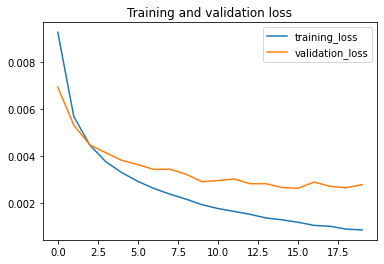

In [ ]:
plot_helper("Training and validation loss",training_loss = training_loss_history,validation_loss = val_loss_history)

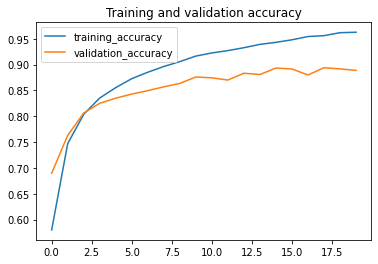

In [ ]:
plot_helper("Training and validation accuracy",training_accuracy = training_acc_history,validation_accuracy = val_acc_history)

### Training on MNIST

In [ ]:
mnist_train,mnist_val = get_MNIST_resnet()

In [ ]:
resnet = models.resnet34(num_classes=10).to(device)


In [ ]:
# tweek model slightly to work with MNIST (change the first convolution so it expects a gray scale image)
resnet.conv1 = torch.nn.Conv2d(1, 64, 
            kernel_size=(7, 7), 
            stride=(2, 2), 
            padding=(3, 3), bias=False).to(device)
# First we define the optimizer
optimizer = torch.optim.Adam(resnet.parameters(), lr=3e-4)
# select path to save best model 
save_path = base_path + "Resnet/best_MNIST"
#
training_loss_history,training_acc_history,val_loss_history,val_acc_history = train(resnet,optimizer,mnist_train,mnist_val,num_epochs=NUM_EPOCHS,save_path=save_path,evaluate_every_epoch=1)

Training starting ... 

Epoch number 1 --------------------------------------------------
 Training Loss = 0.0008365559624508023, Training Accuracy = 96.74% 
performing validation : 
 validation  loss = 0.0002590863441582769, validation accuracy = 99.02% 
Saving best model so far
Epoch number 2 --------------------------------------------------
 Training Loss = 0.00027115436387248337, Training Accuracy = 98.95% 
performing validation : 
 validation  loss = 0.00017633804236538708, validation accuracy = 99.26% 
Saving best model so far
Epoch number 3 --------------------------------------------------
 Training Loss = 0.00021532687242142856, Training Accuracy = 99.11% 
performing validation : 
 validation  loss = 0.00016875336586963385, validation accuracy = 99.31% 
Saving best model so far
Epoch number 4 --------------------------------------------------
 Training Loss = 0.00017521427071187645, Training Accuracy = 99.30% 
performing validation : 
 validation  loss = 0.0001608514867257326

In [ ]:
print(training_loss_history)
print(training_acc_history)
print(val_loss_history)
print(val_acc_history)
np.save(base_path + "Resnet/MNIST_train_loss.npy",np.array(training_loss_history))
np.save(base_path + "Resnet/MNIST_train_acc.npy",np.array(training_acc_history))
np.save(base_path + "Resnet/MNIST_val_loss.npy",np.array(val_loss_history))
np.save(base_path + "Resnet/MNIST_val_acc.npy",np.array(val_acc_history))

[tensor(0.0008, grad_fn=<ToCopyBackward0>), tensor(0.0003, grad_fn=<ToCopyBackward0>), tensor(0.0002, grad_fn=<ToCopyBackward0>), tensor(0.0002, grad_fn=<ToCopyBackward0>), tensor(0.0002, grad_fn=<ToCopyBackward0>), tensor(0.0001, grad_fn=<ToCopyBackward0>), tensor(0.0001, grad_fn=<ToCopyBackward0>), tensor(0.0001, grad_fn=<ToCopyBackward0>), tensor(9.7388e-05, grad_fn=<ToCopyBackward0>), tensor(8.5777e-05, grad_fn=<ToCopyBackward0>)]
[tensor(0.9674), tensor(0.9895), tensor(0.9911), tensor(0.9930), tensor(0.9941), tensor(0.9938), tensor(0.9945), tensor(0.9952), tensor(0.9961), tensor(0.9966)]
[tensor(0.0003), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0001), tensor(0.0002), tensor(0.0001), tensor(0.0002)]
[tensor(0.9902), tensor(0.9926), tensor(0.9931), tensor(0.9935), tensor(0.9942), tensor(0.9926), tensor(0.9938), tensor(0.9924), tensor(0.9948), tensor(0.9941)]


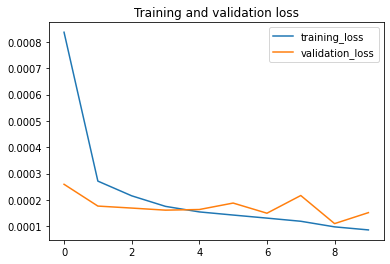

In [ ]:
plot_helper("Training and validation loss",training_loss = training_loss_history,validation_loss = val_loss_history)

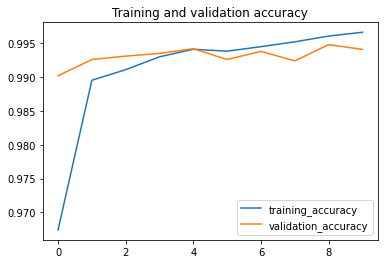

In [ ]:
plot_helper("Training and validation accuracy",training_accuracy = training_acc_history,validation_accuracy = val_acc_history)

## GoogleNet training

### Training on MNIST

In [ ]:
mnist_train,mnist_val = get_MNIST_googlenet()

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [ ]:
googlenet = models.googlenet(num_classes= 10)
googlenet.conv1 = nn.Sequential(
    torch.nn.Conv2d(1, 64, 
            kernel_size=(7, 7), 
            stride=(2, 2), 
            padding=(3, 3), bias=False),
            torch.nn.BatchNorm2d(64,eps=0.001)
)
googlenet = googlenet.to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/googlenet.py:50: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  FutureWarning,


In [ ]:
# First we define the optimizer
optimizer = torch.optim.Adam(googlenet.parameters(), lr=3e-4)
# select path to save best model 
save_path = base_path + "Googlenet/best_MNIST"
#
training_loss_history,training_acc_history,val_loss_history,val_acc_history = train(googlenet,optimizer,mnist_train,mnist_val,num_epochs=NUM_EPOCHS,save_path=save_path,evaluate_every_epoch=1,is_googleNet=True)

Training starting ... 

Epoch number 1 --------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


 Training Loss = 0.0015734251355752349, Training Accuracy = 96.83% 
performing validation : 
 validation  loss = 8.447791515209246e-07, validation accuracy = 98.93% 
Saving best model so far
Epoch number 2 --------------------------------------------------
 Training Loss = 0.000491878017783165, Training Accuracy = 98.87% 
performing validation : 
 validation  loss = 1.0138396078218648e-07, validation accuracy = 99.23% 
Saving best model so far
Epoch number 3 --------------------------------------------------
 Training Loss = 0.00039121348527260125, Training Accuracy = 99.03% 
performing validation : 
 validation  loss = 5.27629197222268e-07, validation accuracy = 99.05% 
Epoch number 4 --------------------------------------------------
 Training Loss = 0.00033850508043542504, Training Accuracy = 99.20% 
performing validation : 
 validation  loss = 3.131744819029336e-08, validation accuracy = 99.45% 
Saving best model so far
Epoch number 5 -----------------------------------------------

In [ ]:
print(training_loss_history)
print(training_acc_history)
print(val_loss_history)
print(val_acc_history)
np.save(base_path + "Googlenet/MNIST_train_loss.npy",np.array(training_loss_history))
np.save(base_path + "Googlenet/MNIST_train_acc.npy",np.array(training_acc_history))
np.save(base_path + "Googlenet/MNIST_val_loss.npy",np.array(val_loss_history))
np.save(base_path + "Googlenet/MNIST_val_acc.npy",np.array(val_acc_history))

[tensor(0.0016), tensor(0.0005), tensor(0.0004), tensor(0.0003), tensor(0.0003), tensor(0.0003), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002)]
[tensor(0.9683), tensor(0.9887), tensor(0.9903), tensor(0.9920), tensor(0.9935), tensor(0.9937), tensor(0.9946), tensor(0.9948), tensor(0.9956), tensor(0.9954)]
[tensor(8.4478e-07), tensor(1.0138e-07), tensor(5.2763e-07), tensor(3.1317e-08), tensor(2.5915e-08), tensor(3.3377e-08), tensor(1.5116e-08), tensor(4.0745e-08), tensor(2.9615e-08), tensor(1.0117e-08)]
[tensor(0.9893), tensor(0.9923), tensor(0.9905), tensor(0.9945), tensor(0.9937), tensor(0.9933), tensor(0.9941), tensor(0.9934), tensor(0.9908), tensor(0.9941)]


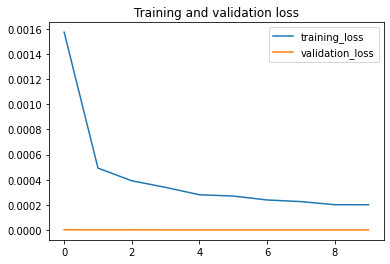

In [ ]:
plot_helper("Training and validation loss",training_loss = training_loss_history,validation_loss = val_loss_history)

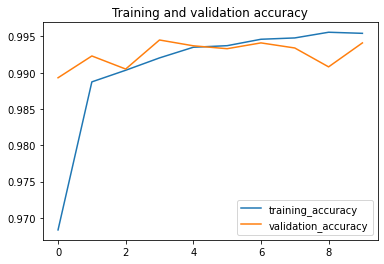

In [ ]:
plot_helper("Training and validation accuracy",training_accuracy = training_acc_history,validation_accuracy = val_acc_history)

### Training on CIFAR

In [ ]:
mnist_train,mnist_val = get_CIFAR_googlenet()

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .
Files already downloaded and verified


In [ ]:
googlenet = models.googlenet(num_classes= 10).to(device)

/usr/local/lib/python3.7/dist-packages/torchvision/models/googlenet.py:50: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  FutureWarning,


In [ ]:
# First we define the optimizer
optimizer = torch.optim.Adam(googlenet.parameters(), lr=3e-4)
# select path to save best model 
save_path = base_path + "Googlenet/best_CIFAR"
#
training_loss_history,training_acc_history,val_loss_history,val_acc_history = train(googlenet,optimizer,mnist_train,mnist_val,num_epochs=20,save_path=save_path,evaluate_every_epoch=1,is_googleNet=True)

Training starting ... 

Epoch number 1 --------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


 Training Loss = 0.01615081913769245, Training Accuracy = 52.74% 
performing validation : 
 validation  loss = 0.0002963817387353629, validation accuracy = 63.26% 
Saving best model so far
Epoch number 2 --------------------------------------------------
 Training Loss = 0.010319840162992477, Training Accuracy = 71.21% 
performing validation : 
 validation  loss = 0.00021479694987647235, validation accuracy = 74.82% 
Saving best model so far
Epoch number 3 --------------------------------------------------
 Training Loss = 0.007801981642842293, Training Accuracy = 79.19% 
performing validation : 
 validation  loss = 0.00018452000222168863, validation accuracy = 79.96% 
Saving best model so far
Epoch number 4 --------------------------------------------------
 Training Loss = 0.006374957039952278, Training Accuracy = 83.27% 
performing validation : 
 validation  loss = 0.00015267590060830116, validation accuracy = 81.48% 
Saving best model so far
Epoch number 5 -------------------------

In [ ]:
print(training_loss_history)
print(training_acc_history)
print(val_loss_history)
print(val_acc_history)
np.save(base_path + "Googlenet/CIFAR_train_loss.npy",np.array(training_loss_history))
np.save(base_path + "Googlenet/CIFAR_train_acc.npy",np.array(training_acc_history))
np.save(base_path + "Googlenet/CIFAR_val_loss.npy",np.array(val_loss_history))
np.save(base_path + "Googlenet/CIFAR_val_acc.npy",np.array(val_acc_history))

[tensor(0.0162), tensor(0.0103), tensor(0.0078), tensor(0.0064), tensor(0.0054), tensor(0.0046), tensor(0.0040), tensor(0.0034), tensor(0.0028), tensor(0.0024), tensor(0.0020), tensor(0.0017), tensor(0.0014), tensor(0.0013), tensor(0.0012), tensor(0.0009), tensor(0.0009), tensor(0.0009), tensor(0.0007), tensor(0.0007)]
[tensor(0.5274), tensor(0.7121), tensor(0.7919), tensor(0.8327), tensor(0.8597), tensor(0.8813), tensor(0.8993), tensor(0.9163), tensor(0.9310), tensor(0.9413), tensor(0.9535), tensor(0.9627), tensor(0.9696), tensor(0.9705), tensor(0.9748), tensor(0.9819), tensor(0.9818), tensor(0.9817), tensor(0.9849), tensor(0.9855)]
[tensor(0.0003), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0003), tensor(0.0002), tensor(0.0002), tensor(8.9684e-05), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002)]
[tensor(0.6326), tensor(0.7482), 

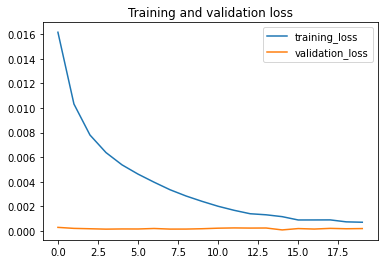

In [ ]:
plot_helper("Training and validation loss",training_loss = training_loss_history,validation_loss = val_loss_history)

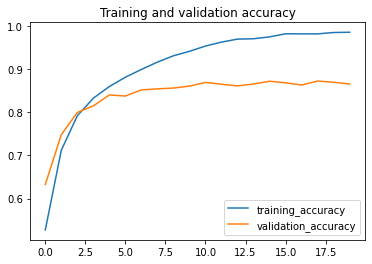

In [ ]:
plot_helper("Training and validation accuracy",training_accuracy = training_acc_history,validation_accuracy = val_acc_history)

## VGG Training

### Training on MNIST

In [ ]:
mnist_train,mnist_val = get_MNIST_VGG(batch_size=16)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [ ]:
vgg16 = models.vgg11(num_classes=10).to(device)

In [ ]:
# First we define the optimizer
optimizer = torch.optim.Adam(vgg16.parameters(), lr=3e-4)
# select path to save best model
save_path = base_path + "VGG/best_MNIST"
#
training_loss_history,training_acc_history,val_loss_history,val_acc_history = train(vgg16,optimizer,mnist_train,mnist_val,num_epochs=10,save_path=save_path,evaluate_every_epoch=1)

Training starting ... 

Epoch number 1 --------------------------------------------------
 Training Loss = 0.0013270180206745863, Training Accuracy = 94.54% 
Time taken for an epoch -8.5e+02 second
performing validation : 
 validation  loss = 2.0987810600558987e-08, validation accuracy = 99.04% 
Saving best model so far
Epoch number 2 --------------------------------------------------
 Training Loss = 0.00033712241565808654, Training Accuracy = 98.74% 
Time taken for an epoch -8.4e+02 second
performing validation : 
 validation  loss = 4.68972807254886e-08, validation accuracy = 99.26% 
Saving best model so far
Epoch number 3 --------------------------------------------------
 Training Loss = 0.00022485827503260225, Training Accuracy = 99.18% 
Time taken for an epoch -8.4e+02 second
performing validation : 
 validation  loss = 9.067035477983154e-08, validation accuracy = 99.12% 
Epoch number 4 --------------------------------------------------
 Training Loss = 0.00016544874233659357, T

In [ ]:
print(training_loss_history)
print(training_acc_history)
print(val_loss_history)
print(val_acc_history)
np.save(base_path + "VGG/MNIST_train_loss.npy",np.array(training_loss_history))
np.save(base_path + "VGG/MNIST_train_acc.npy",np.array(training_acc_history))
np.save(base_path + "VGG/MNIST_val_loss.npy",np.array(val_loss_history))
np.save(base_path + "VGG/MNIST_val_acc.npy",np.array(val_acc_history))

[tensor(0.0013), tensor(0.0003), tensor(0.0002), tensor(0.0002), tensor(0.0001), tensor(0.0001), tensor(8.4912e-05), tensor(8.3262e-05), tensor(6.2994e-05), tensor(6.5908e-05)]
[tensor(0.9454), tensor(0.9874), tensor(0.9918), tensor(0.9937), tensor(0.9947), tensor(0.9955), tensor(0.9967), tensor(0.9968), tensor(0.9975), tensor(0.9976)]
[tensor(2.0988e-08), tensor(4.6897e-08), tensor(9.0670e-08), tensor(6.9923e-07), tensor(3.8743e-10), tensor(2.3842e-10), tensor(4.6752e-09), tensor(7.4052e-08), tensor(7.5398e-10), tensor(0.)]
[tensor(0.9904), tensor(0.9926), tensor(0.9912), tensor(0.9904), tensor(0.9935), tensor(0.9907), tensor(0.9915), tensor(0.9920), tensor(0.9921), tensor(0.9926)]


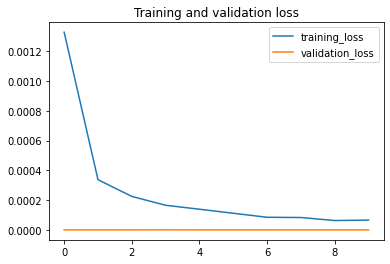

In [ ]:
plot_helper("Training and validation loss",training_loss = training_loss_history,validation_loss = val_loss_history)

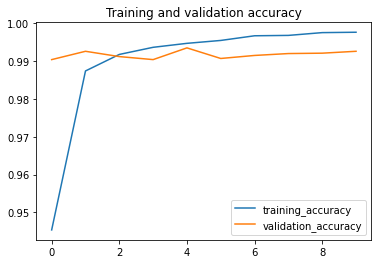

In [ ]:
plot_helper("Training and validation accuracy",training_accuracy = training_acc_history,validation_accuracy = val_acc_history)

### Training on CIFAR

In [ ]:
CIFAR_train,CIFAR_val = get_CIFAR_VGG()

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
vgg = models.vgg16(num_classes=10).to(device)

In [ ]:
# First we define the optimizer
optimizer = torch.optim.Adam(vgg.parameters(), lr=3e-4)
# select path to save best model 
save_path = base_path + "VGG/best_CIFAR"
#
training_loss_history,training_acc_history,val_loss_history,val_acc_history = train(vgg,optimizer,CIFAR_train,CIFAR_val,num_epochs=20,save_path=save_path,evaluate_every_epoch=1)

Training starting ... 

Epoch number 1 --------------------------------------------------
 Training Loss = 0.012708607129752636, Training Accuracy = 39.94% 
Time taken for an epoch -4.5e+03 second
performing validation : 
 validation  loss = 0.00019568031711969525, validation accuracy = 50.96% 
Saving best model so far
Epoch number 2 --------------------------------------------------
 Training Loss = 0.00802997313439846, Training Accuracy = 63.53% 
Time taken for an epoch -4.8e+03 second
performing validation : 
 validation  loss = 0.00023065244022291154, validation accuracy = 69.11% 
Saving best model so far
Epoch number 3 --------------------------------------------------
 Training Loss = 0.005560519173741341, Training Accuracy = 75.17% 
Time taken for an epoch -4.8e+03 second
performing validation : 
 validation  loss = 0.00017257998115383089, validation accuracy = 74.79% 
Saving best model so far
Epoch number 4 --------------------------------------------------
 Training Loss = 0.0

In [ ]:
print(training_loss_history)
print(training_acc_history)
print(val_loss_history)
print(val_acc_history)
np.save(base_path + "VGG/CIFAR_train_loss.npy",np.array(training_loss_history))
np.save(base_path + "VGG/CIFAR_train_acc.npy",np.array(training_acc_history))
np.save(base_path + "VGG/CIFAR_val_loss.npy",np.array(val_loss_history))
np.save(base_path + "VGG/CIFAR_val_acc.npy",np.array(val_acc_history))

[tensor(0.0127), tensor(0.0080), tensor(0.0056), tensor(0.0039), tensor(0.0025), tensor(0.0015), tensor(0.0010), tensor(0.0008), tensor(0.0006), tensor(0.0006), tensor(0.0005), tensor(0.0004), tensor(0.0004), tensor(0.0004), tensor(0.0004), tensor(0.0003), tensor(0.0003), tensor(0.0003), tensor(0.0003), tensor(0.0003)]
[tensor(0.3994), tensor(0.6353), tensor(0.7517), tensor(0.8271), tensor(0.8903), tensor(0.9370), tensor(0.9548), tensor(0.9675), tensor(0.9760), tensor(0.9773), tensor(0.9797), tensor(0.9827), tensor(0.9832), tensor(0.9847), tensor(0.9845), tensor(0.9871), tensor(0.9860), tensor(0.9884), tensor(0.9871), tensor(0.9890)]
[tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0002), tensor(0.0003), tensor(0.0002), tensor(0.0003), tensor(0.0003), tensor(0.0003), tensor(0.0002), tensor(0.0002), tensor(0.0004), tensor(0.0005), tensor(0.0003), tensor(0.0002), tensor(0.0002), tensor(0.0004), tensor(0.0002)]
[tensor(0.5096), tensor(0.6911), tens

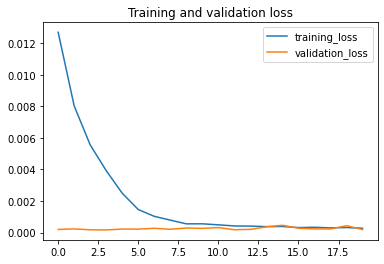

In [ ]:
plot_helper("Training and validation loss",training_loss = training_loss_history,validation_loss = val_loss_history)

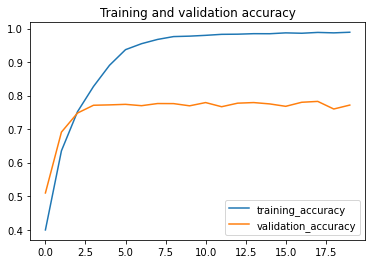

In [ ]:
plot_helper("Training and validation accuracy",training_accuracy = training_acc_history,validation_accuracy = val_acc_history)

## Custom model Training

### Model defnition

In [12]:
## Defining byuilding blocks of the model
class BasicConv2d(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, **kwargs: Any) -> None:
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x: Tensor) -> Tensor:
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)

class Inception(nn.Module):
    def __init__(
        self,
        in_channels: int,
        ch1x1: int,
        ch3x3red: int,
        ch3x3: int,
        ch5x5red: int,
        ch5x5: int,
        pool_proj: int,
        conv_block: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if conv_block is None:
            conv_block = BasicConv2d
        self.branch1 = conv_block(in_channels, ch1x1, kernel_size=1)

        self.branch2 = nn.Sequential(
            conv_block(in_channels, ch3x3red, kernel_size=1), conv_block(ch3x3red, ch3x3, kernel_size=3, padding=1)
        )

        self.branch3 = nn.Sequential(
            conv_block(in_channels, ch5x5red, kernel_size=1),
            # Here, kernel_size=3 instead of kernel_size=5 is a known bug.
            # Please see https://github.com/pytorch/vision/issues/906 for details.
            conv_block(ch5x5red, ch5x5, kernel_size=3, padding=1),
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1, ceil_mode=True),
            conv_block(in_channels, pool_proj, kernel_size=1),
        )

    def _forward(self, x: Tensor) -> List[Tensor]:
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)

        outputs = [branch1, branch2, branch3, branch4]
        return outputs

    def forward(self, x: Tensor) -> Tensor:
        outputs = self._forward(x)
        return torch.cat(outputs, 1)

In [13]:
# defining the model
class ResGooglenet(nn.Module):
  def __init__(self):
    super(ResGooglenet,self).__init__()
    #
    self.conv1 = BasicConv2d(3, 64, kernel_size=7, stride=2, padding=3)
    self.maxpool1 = nn.MaxPool2d(3, stride=2, ceil_mode=True)
    self.conv2 = BasicConv2d(64, 64, kernel_size=1)
    self.conv3 = BasicConv2d(64, 192, kernel_size=3, padding=1)
    self.maxpool2 = nn.MaxPool2d(3, stride=2, ceil_mode=True)
    #

    self.inception3a = Inception(192, 64, 96, 128, 16, 32, 32)
    self.inception3b = Inception(256, 128, 128, 192, 32, 96, 64)
    self.inception4a = Inception(480, 192, 96, 208, 16, 48, 64)
    self.downsample1 = nn.Conv2d(512,192,1)
    self.maxpool3 = nn.MaxPool2d(3, stride=2, ceil_mode=True)
    #

    self.inception4b = Inception(192, 160, 112, 224, 24, 64, 64)
    self.inception4c = Inception(512, 128, 128, 256, 24, 64, 64)
    self.inception4d = Inception(512, 112, 144, 288, 32, 64, 64)
    self.downsample2 = nn.Conv2d(528,192,1)
    self.maxpool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True)
    
    #
    self.inception4e = Inception(192, 256, 160, 320, 32, 128, 128)
    self.inception5a = Inception(832, 256, 160, 320, 32, 128, 128)
    self.inception5b = Inception(832, 384, 192, 384, 48, 128, 128)

    #

    self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    self.dropout = nn.Dropout(p=0.2)
    self.fc = nn.Linear(1024, 10)


  def forward(self, x: Tensor) -> Tuple[Tensor, Optional[Tensor], Optional[Tensor]]:
      # N x 3 x 224 x 224
      x = self.conv1(x)
      # N x 64 x 112 x 112
      x = self.maxpool1(x)
      # N x 64 x 56 x 56
      x = self.conv2(x)
      # N x 64 x 56 x 56
      x = self.conv3(x)
      # N x 192 x 56 x 56
      x = self.maxpool2(x)

      # N x 192 x 28 x 28
      res1 = x

      
      x = self.inception3a(x)
      # N x 256 x 28 x 28
      x = self.inception3b(x)
      # N x 480 x 28 x 28

      x = self.inception4a(x)
      # N x 512 x 28 x 28
      x = F.relu(self.downsample1(x))
      # N x 192 x 28 x 28
      x = x + res1

      x = self.maxpool3(x)
      # N x 192 x 14 x 14

      res2 = x

      x = self.inception4b(x)
      # N x 256 x 14 x 14

      x = self.inception4c(x)
      # N x 480 x 14 x 14

      x = self.inception4d(x)
      # N x 512 x 14 x 14

      x = F.relu(self.downsample2(x))
      # N x 192 x 14 x 14
      x = x + res2

      x = self.maxpool4(x)
      # N x 192 x 7 x 7


      x = self.inception4e(x)
      # N x 832 x 7 x 7

      x = self.inception5a(x)
      # N x 832 x 7 x 7

      x = self.inception5b(x)
      # N x 1024 x 7 x 7

      x = self.avgpool(x)
      # N x 1024 x 1 x 1

      x = torch.flatten(x, 1)
      # N x 1024
      x = self.dropout(x)
      x = self.fc(x)
      # N x 1000 (num_classes)
      return x

### Training on MNIST

In [14]:
mnist_train,mnist_val = get_MNIST_googlenet()

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


In [15]:
res_googlenet = ResGooglenet()
res_googlenet.conv1 = BasicConv2d(1, 64, kernel_size=7, stride=2, padding=3)
res_googlenet = res_googlenet.to(device)

In [16]:
# First we define the optimizer
optimizer = torch.optim.Adam(res_googlenet.parameters(), lr=3e-4)
# select path to save best model 
save_path = base_path + "ResGooglenet/best_MNIST"
#
training_loss_history,training_acc_history,val_loss_history,val_acc_history = train(res_googlenet,optimizer,mnist_train,mnist_val,num_epochs=NUM_EPOCHS,save_path=save_path,evaluate_every_epoch=1)

Training starting ... 

Epoch number 1 --------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


 Training Loss = 0.0007877383613958955, Training Accuracy = 97.27% 
Time taken for an epoch -7.6e+02 second
performing validation : 
 validation  loss = 8.973887020147231e-07, validation accuracy = 98.83% 
Saving best model so far
Epoch number 2 --------------------------------------------------
 Training Loss = 0.00022730600903742015, Training Accuracy = 99.13% 
Time taken for an epoch -7.6e+02 second
performing validation : 
 validation  loss = 5.159004246024779e-08, validation accuracy = 99.45% 
Saving best model so far
Epoch number 3 --------------------------------------------------
 Training Loss = 0.00018296745838597417, Training Accuracy = 99.28% 
Time taken for an epoch -7.6e+02 second
performing validation : 
 validation  loss = 4.685015753125299e-08, validation accuracy = 99.26% 
Epoch number 4 --------------------------------------------------
 Training Loss = 0.00014239622396416962, Training Accuracy = 99.46% 
Time taken for an epoch -7.6e+02 second
performing validation :

In [17]:
print(training_loss_history)
print(training_acc_history)
print(val_loss_history)
print(val_acc_history)
np.save(base_path + "ResGooglenet/MNIST_train_loss.npy",np.array(training_loss_history))
np.save(base_path + "ResGooglenet/MNIST_train_acc.npy",np.array(training_acc_history))
np.save(base_path + "ResGooglenet/MNIST_val_loss.npy",np.array(val_loss_history))
np.save(base_path + "ResGooglenet/MNIST_val_acc.npy",np.array(val_acc_history))

[tensor(0.0008), tensor(0.0002), tensor(0.0002), tensor(0.0001), tensor(0.0001), tensor(0.0001), tensor(0.0001), tensor(9.6649e-05), tensor(7.3644e-05), tensor(7.7673e-05)]
[tensor(0.9727), tensor(0.9913), tensor(0.9928), tensor(0.9946), tensor(0.9945), tensor(0.9956), tensor(0.9960), tensor(0.9961), tensor(0.9968), tensor(0.9969)]
[tensor(8.9739e-07), tensor(5.1590e-08), tensor(4.6850e-08), tensor(4.0363e-08), tensor(5.6421e-08), tensor(1.3220e-08), tensor(5.6605e-08), tensor(1.1307e-08), tensor(2.9320e-08), tensor(2.9459e-09)]
[tensor(0.9883), tensor(0.9945), tensor(0.9926), tensor(0.9937), tensor(0.9935), tensor(0.9925), tensor(0.9911), tensor(0.9936), tensor(0.9935), tensor(0.9931)]


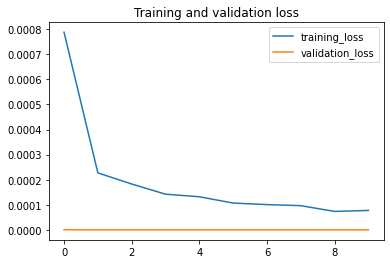

In [18]:
plot_helper("Training and validation loss",training_loss = training_loss_history,validation_loss = val_loss_history)

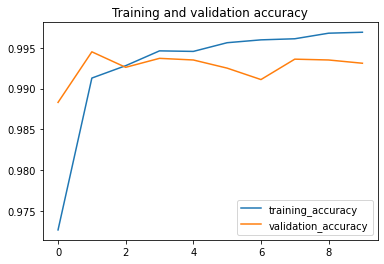

In [19]:
plot_helper("Training and validation accuracy",training_accuracy = training_acc_history,validation_accuracy = val_acc_history)

### Training on CIFAR

In [ ]:
CIFAR_train,CIFAR_val = get_CIFAR_googlenet()

In [ ]:
res_googlenet = ResGooglenet().to(device)

In [ ]:
# First we define the optimizer
optimizer = torch.optim.Adam(res_googlenet.parameters(), lr=3e-4)
# select path to save best model 
save_path = base_path + "ResGooglenet/best_MNIST"
#
training_loss_history,training_acc_history,val_loss_history,val_acc_history = train(res_googlenet,optimizer,CIFAR_train,CIFAR_val,num_epochs=NUM_EPOCHS,save_path=save_path,evaluate_every_epoch=1)

In [ ]:
print(training_loss_history)
print(training_acc_history)
print(val_loss_history)
print(val_acc_history)
np.save(base_path + "ResGooglenet/CIFAR_train_loss.npy",np.array(training_loss_history))
np.save(base_path + "ResGooglenet/CIFAR_train_acc.npy",np.array(training_acc_history))
np.save(base_path + "ResGooglenet/CIFAR_val_loss.npy",np.array(val_loss_history))
np.save(base_path + "ResGooglenet/CIFAR_val_acc.npy",np.array(val_acc_history))

#Visualizations

## Importing all models

In [ ]:
## CIFAR Resnet 
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(nn.Module):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out
CIFAR_resnet = ResNet9(3, 10).to(device)
CIFAR_resnet.load_state_dict(torch.load(base_path + "Resnet/best_CIFAR",map_location=device))

## MNIST_Resnet
MNIST_resnet = models.resnet34(num_classes=10).to(device)
MNIST_resnet.conv1 = torch.nn.Conv2d(1, 64, 
            kernel_size=(7, 7), 
            stride=(2, 2), 
            padding=(3, 3), bias=False)
MNIST_resnet =MNIST_resnet.to(device)

MNIST_resnet.load_state_dict(torch.load(base_path + "Resnet/best_MNIST",map_location=device))



<All keys matched successfully>

In [ ]:
## MNIST google net
MNIST_googlenet = models.googlenet(num_classes= 10)
MNIST_googlenet.conv1 = nn.Sequential(
    torch.nn.Conv2d(1, 64, 
            kernel_size=(7, 7), 
            stride=(2, 2), 
            padding=(3, 3), bias=False),
            torch.nn.BatchNorm2d(64,eps=0.001)
)
MNIST_googlenet = MNIST_googlenet.to(device)
MNIST_googlenet.load_state_dict(torch.load(base_path + "Googlenet/best_MNIST",map_location=device))

## CIFAR google net
CIFAR_googlenet = models.googlenet(num_classes= 10).to(device)
CIFAR_googlenet.load_state_dict(torch.load(base_path + "Googlenet/best_CIFAR",map_location=device))

/usr/local/lib/python3.7/dist-packages/torchvision/models/googlenet.py:50: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  FutureWarning,


<All keys matched successfully>

In [ ]:
# MNIST VGG
MNIST_vgg = models.vgg11(num_classes=10).to(device)
MNIST_vgg.load_state_dict(torch.load(base_path + "VGG/best_MNIST",map_location=device))
#CIFAR VGG
CIFAR_vgg = models.vgg16(num_classes=10).to(device)
CIFAR_vgg.load_state_dict(torch.load(base_path + "VGG/best_CIFAR",map_location=device))

<All keys matched successfully>

## Importing all training curves

In [ ]:
def retrive_history(model_name,data_name):
  return np.load(base_path + model_name+"/{}_train_loss.npy".format(data_name))\
  ,np.load(base_path + model_name+"/{}_train_acc.npy".format(data_name))\
  ,np.load(base_path + model_name+"/{}_val_loss.npy".format(data_name))\
  ,np.load(base_path + model_name+"/{}_val_acc.npy".format(data_name))


In [ ]:
## CIFAR
Resnet_t_l_CIFAR,Resnet_t_a_CIFAR,Resnet_v_l_CIFAR,Resnet_v_a_CIFAR = retrive_history("Resnet","CIFAR")

Googlenet_t_l_CIFAR,Googlenet_t_a_CIFAR,Googlenet_v_l_CIFAR,Googlenet_v_a_CIFAR = retrive_history("Googlenet","CIFAR")

VGG_t_l_CIFAR,VGG_t_a_CIFAR,VGG_v_l_CIFAR,VGG_v_a_CIFAR = retrive_history("VGG","CIFAR")
## MNIST
Resnet_t_l_MNIST,Resnet_t_a_MNIST,Resnet_v_l_MNIST,Resnet_v_a_MNIST = retrive_history("Resnet","MNIST")

Googlenet_t_l_MNIST,Googlenet_t_a_MNIST,Googlenet_v_l_MNIST,Googlenet_v_a_MNIST = retrive_history("Googlenet","MNIST")

VGG_t_l_MNIST,VGG_t_a_MNIST,VGG_v_l_MNIST,VGG_v_a_MNIST = retrive_history("VGG","MNIST")

## Helper to get correct and wrong model predictions

In [ ]:

def get_k_model_predictions(model,dataloader,k=10,is_correct=True,is_googleNet=False): # dataloader batch size must be 1
#### TODO: assert batch size of dataloader
  result={}
  for idx,(img,label) in enumerate(dataloader):
    if len(result == k):
      break
    img,label = img.to(device), label.to(device)

    with torch.no_grad():
      if is_googleNet:
        output,_,_ = model(img)
      else:
        output = model(img)

    preds = torch.argmax(output,axis=1)

    if is_correct:
      if preds == label:
        result[idx] = preds
    else:
      if preds != label:
        result[idx] = preds

  #assert completion
  if len(result) != k:
    raise Exception
  
  return result


def plot_predictions(result,dataloader,k=10):
  pass


## CIFAR Visualizations

### Training and validation curves

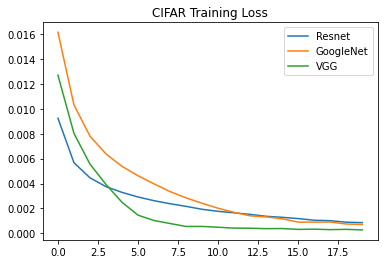

In [ ]:
plot_helper("CIFAR Training Loss",Resnet=Resnet_t_l_CIFAR,GoogleNet = Googlenet_t_l_CIFAR, VGG = VGG_t_l_CIFAR )

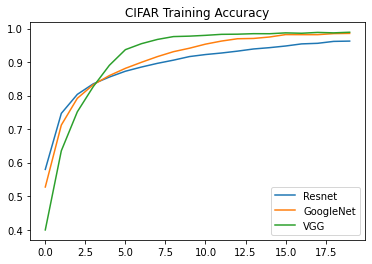

In [ ]:
plot_helper("CIFAR Training Accuracy",Resnet=Resnet_t_a_CIFAR,GoogleNet = Googlenet_t_a_CIFAR, VGG = VGG_t_a_CIFAR )

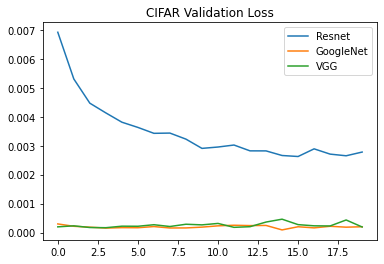

In [ ]:
plot_helper("CIFAR Validation Loss",Resnet=Resnet_v_l_CIFAR,GoogleNet = Googlenet_v_l_CIFAR, VGG = VGG_v_l_CIFAR )

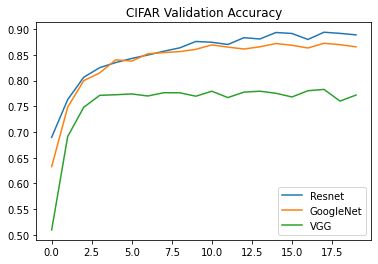

In [ ]:
plot_helper("CIFAR Validation Accuracy",Resnet=Resnet_v_a_CIFAR,GoogleNet = Googlenet_v_a_CIFAR, VGG = VGG_v_a_CIFAR )

## MNIST Visualizations

### Training and validation curves

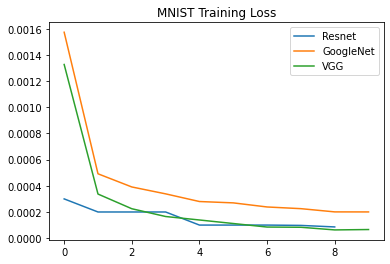

In [ ]:
plot_helper("MNIST Training Loss",Resnet=Resnet_t_l_MNIST,GoogleNet = Googlenet_t_l_MNIST, VGG = VGG_t_l_MNIST )

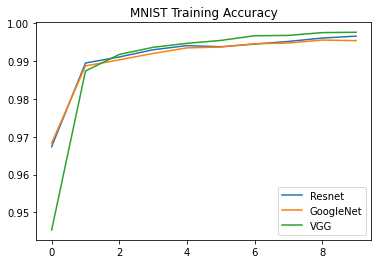

In [ ]:
plot_helper("MNIST Training Accuracy",Resnet=Resnet_t_a_MNIST,GoogleNet = Googlenet_t_a_MNIST, VGG = VGG_t_a_MNIST )

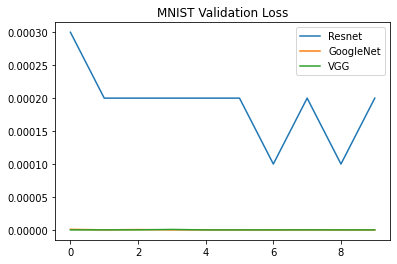

In [ ]:
plot_helper("MNIST Validation Loss",Resnet=Resnet_v_l_MNIST,GoogleNet = Googlenet_v_l_MNIST, VGG = VGG_v_l_MNIST )

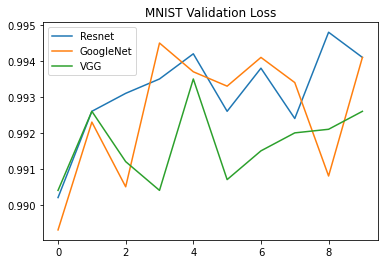

In [ ]:
plot_helper("MNIST Validation Loss",Resnet=Resnet_v_a_MNIST,GoogleNet = Googlenet_v_a_MNIST, VGG = VGG_v_a_MNIST )